# "Training a pistol detector with YOLOv5 and Neuralmagic"
> "An pistol detection model trained with Neuralmagic and deployed using DeepSparse, a sparsity-aware inference engine that allows improved model inference performance on CPU hardware."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Jaco Verster
- categories: [object detection, yolov5, neuralmagic, pistols]

Note: To run this notebook yourself please click on the  "Open In Colab" tag above.

## Step 1: Download the pistol dataset
Download the [Pistols](https://public.roboflow.com/object-detection/pistols/1) dataset from [Roboflow's](https://roboflow.com/) public database. 

Select YOLOv5 from the download formats and copy your unique terminal command into the cell below.

In [1]:
! curl -L "https://public.roboflow.com/ds/xXg040ThIk?key=[YOUR_UNIQUE_KEY]" > data.zip \
  && unzip -q data.zip -d downloads \
  && rm data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3575      0 --:--:-- --:--:-- --:--:--  3575
100 58.4M  100 58.4M    0     0  70.8M      0 --:--:-- --:--:-- --:--:-- 70.8M


## Step 2: Explore the data

To explore the rapid dataset exploration toolset from [Fiftyone](https://voxel51.com/docs/fiftyone/).

To use Fiftyone with Colab we need to install opencv-python-headless==4.5.4.60.

In [ ]:
! pip install -q opencv-python-headless==4.5.4.60 fiftyone

In [ ]:
import fiftyone as fo

# Import dataset by explicitly providing paths to the source images and labels
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv4Dataset,
    data_path="downloads/export/images",
    label_field="ground_truth",
    labels_path="downloads/export/labels",
    classes=["pistol"],
)

# View the data using the interactive dashboard
session = fo.launch_app(dataset)

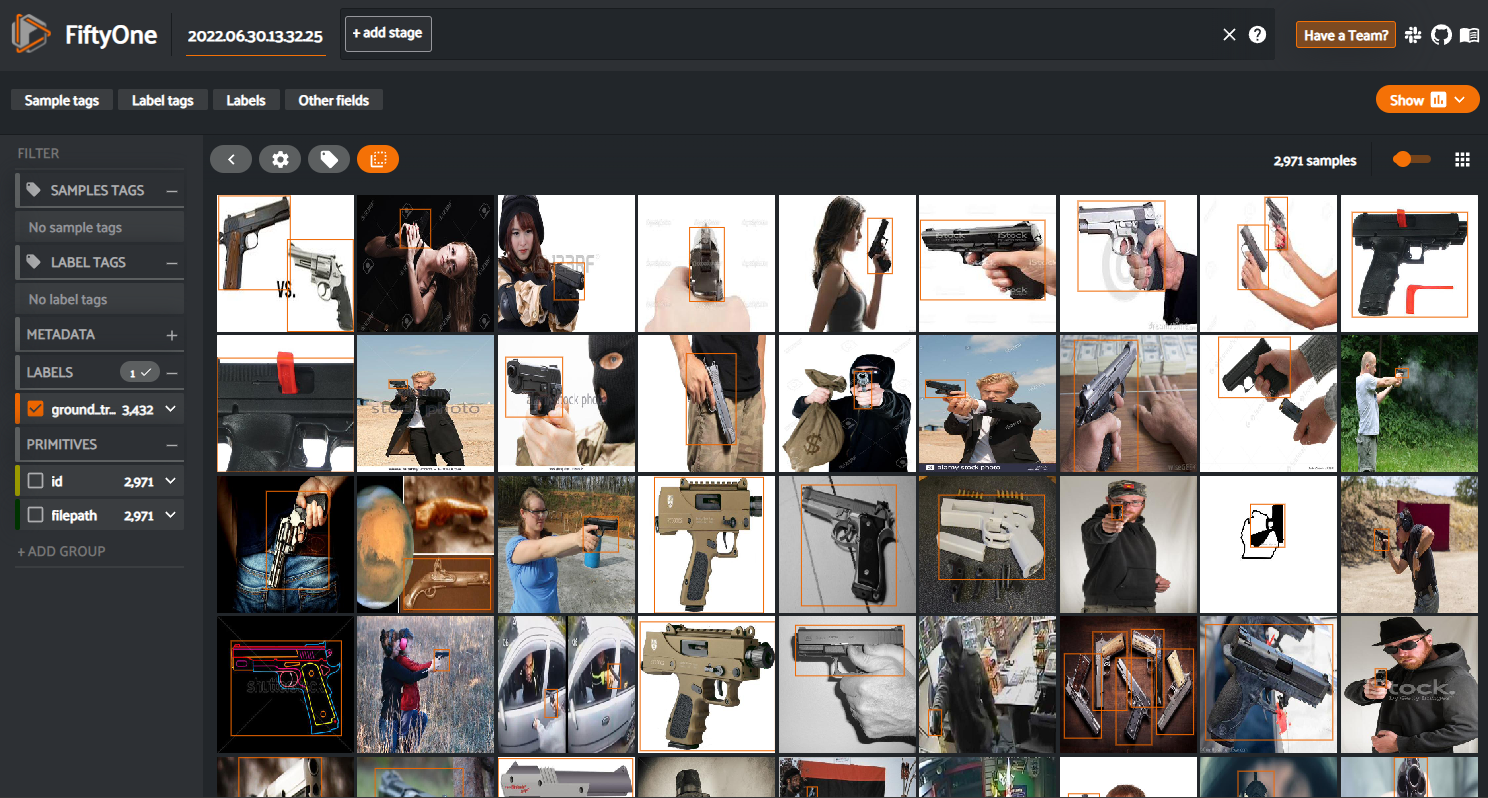

The pistol images seem to be correctly labelled with a good variety of different pistols included in the dataset. The image size is 416x416 for all images.

## Step 3: Split the dataset into train/test/val subsets

Next we can use Fiftyone utilities to split the dataset into three subsets. We define a convenience function called "split_dataset" to help us process the data.

In [9]:
import fiftyone.utils.splits as fous
import os


def split_dataset(dataset, split_dict, output_path):
    fous.random_split(dataset, split_dict, seed=42)
    for tag in list(split_dict.keys()):
        view = dataset.match_tags(tag)
        # Export each split separately
        dir = os.path.join(output_path, tag)
        view.export(
            export_dir=dir,
            dataset_type=fo.types.YOLOv4Dataset,
            label_field="ground_truth",
        )


split_dataset(
    dataset=dataset,
    split_dict={"train": 0.8, "test": 0.1, "val": 0.1},
    output_path="dataset/guns/",
)

 100% |███████████████| 2377/2377 [2.7s elapsed, 0s remaining, 859.1 samples/s]      
 100% |█████████████████| 297/297 [355.2ms elapsed, 0s remaining, 836.1 samples/s]      
 100% |█████████████████| 297/297 [397.3ms elapsed, 0s remaining, 747.5 samples/s]      


To use the dataset with a YOLO training pipeline we need to define a *.yml file that points to the data locations. To read more about training on a custom dataset using YOLOv5, see [Train Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) by the Ultralytics team.

In [10]:
content = """# Train/val/test sets
path: /content/dataset/guns  # dataset root dir
train: train/data  # train images (relative to 'path')
test: test/data  # test images (relative to 'path')
val: val/data  # val images (relative to 'path')

# classes
nc: 1 # number of classes
names: ['pistol']"""

with open("pistols.yml", "w") as f:
    f.write(content)

Remove the downloaded data to clean up the workspace.

In [13]:
! rm -r downloads

## Step 4: Install DeepSparse and SparseML libraries and train our model

To train our own custom model using the pistol dataset we will use the [SparseML YOLOv5 Integration](https://github.com/neuralmagic/sparseml/tree/main/src/sparseml/yolov5) provided by Neuralmagic.

First, we install the required libraries and we grab the transfer learning recipe from their repo.

Note, you can also use the built-in recipe, like this:

`--recipe zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned-aggressive_96`

However, if you want to specify the number of epochs or the learning rate rather use the downloaded recipe.

In [ ]:
! pip install -q deepsparse[yolo] sparseml[torchvision]

In [ ]:
! curl -LO "https://raw.githubusercontent.com/neuralmagic/sparseml/main/integrations/ultralytics-yolov5/recipes/yolov5.transfer_learn_pruned.md"

Now we can train our model using transfer learning on YOLOv5s (small) and the downloaded recipe. We use the CLI and run `sparseml.yolov5.train` 

The arguments we use with `sparseml.yolov5.train` are shown below. For more info on each argument, just run:

In [ ]:
! sparseml.yolov5.train --help

For more information on the pre-trained weights you can use with YOLOv5 feel free to refer to the [Sparse Transfer Learning With YOLOv5](https://github.com/neuralmagic/sparseml/blob/main/integrations/ultralytics-yolov5/tutorials/yolov5_sparse_transfer_learning.md) example.

We train our model for 50 epochs. Click on "Show Output" to view the results

In [17]:
#collapse-output
! sparseml.yolov5.train \
  --data pistols.yml \
  --cfg models_v5.0/yolov5s.yaml \
  --weights zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned-aggressive_96 \
  --hyp data/hyps/hyp.finetune.yaml \
  --batch-size -1 \
  --imgsz 416 \
  --recipe yolov5.transfer_learn_pruned.md

train: weights=zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned-aggressive_96, cfg=models_v5.0/yolov5s.yaml, data=pistols.yml, hyp=data/hyps/hyp.finetune.yaml, epochs=300, batch_size=-1, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=0, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, recipe=yolov5.transfer_learn_pruned.md, disable_ema=False, max_train_steps=-1, max_eval_steps=-1, one_shot=False, num_export_samples=0
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
fatal: not a git repository (or any of the parent directories): .git
YOLOv5 🚀 2022-6-30 torch 1.9.1+cu102 CUDA:

## Step 4: Export the Sparse Model to ONNX format for CPU inference

The DeepSparse Engine accepts ONNX formats and is engineered to significantly speed up inference on CPUs for the sparsified models from this integration. To convert the YOLOv5 model to ONNX format run:

In [ ]:
! sparseml.yolov5.export_onnx \
  --weights yolov5_runs/train/exp/weights/best.pt \
  --imgsz 416 \
  --dynamic

## Step 5: DeepSparse Engine model deployment

To validate the model on our test set in the DeepSparse Engine we run the following command, again using the CLI interface.

Note that the DeepSparse engine uses the CPU for inference and it might take a minute or two to run through the test set.

In [24]:
! sparseml.yolov5.val_onnx \
  --model_path yolov5_runs/train/exp/weights/best.onnx \
  --batch-size 33 \
  --imgsz 416 \
  --task test \
  --data pistols.yml

val_onnx: data=pistols.yml, model_path=yolov5_runs/train/exp/weights/best.onnx, batch_size=33, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=../usr/local/lib/python3.7/dist-packages/sparseml/yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, engine=deepsparse, num_cores=None
val_onnx: data=pistols.yml, model_path=yolov5_runs/train/exp/weights/best.onnx, batch_size=33, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=../usr/local/lib/python3.7/dist-packages/sparseml/yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, engine=deepsparse, num_cores=None
fatal: not a git repository (or any of the parent directories): .git
YOLOv5 🚀 2022-6-30 torch 1.9.1+cu102 CUDA:0 (Tesla T4, 15110MiB)

DeepSparse 

## Step 6: Compare sparsified ONNX model with PyTorch version

We can also run the model trained with the Neuralmagic CLI using the Ultralytics YOLO library. We will compare the inference times for the ONNX model (\*.onnx) run on the DeepSparse engine with the PyTorch version (*.pt) run on CPU.

We clone the YOLOv5 library and install dependencies.

In [ ]:
! git clone https://github.com/ultralytics/yolov5
! pip install -q -r yolov5/requirements.txt

Now we run the ONNx model on a test image.

Then we run inference on the same image using the PyTorch model.

In [ ]:
!python yolov5/detect.py \
  --weights /content/yolov5_runs/train/exp/weights/best.pt \
  --source  \
  --imgsz 416 \
  --device cpu

## Step 7: Run the model on a YouTube video using Ultralytics library

Simply run inference with the YOLOv5 detect.py scrip using the *.pt weights file instead of the *.onnx one.

For this example we will use a YouTube scene from John Wick making Revolver to test the model. Inference will be done using the GPU this time.

In [ ]:
!python yolov5/detect.py \
  --weights /content/yolov5_runs/train/exp/weights/best.pt \
  --source "https://www.youtube.com/watch?v=nB0A4pFIOA0" \
  --conf-thres=0.6 \
  --imgsz 416

Below are a few screenshots from the annotated video.

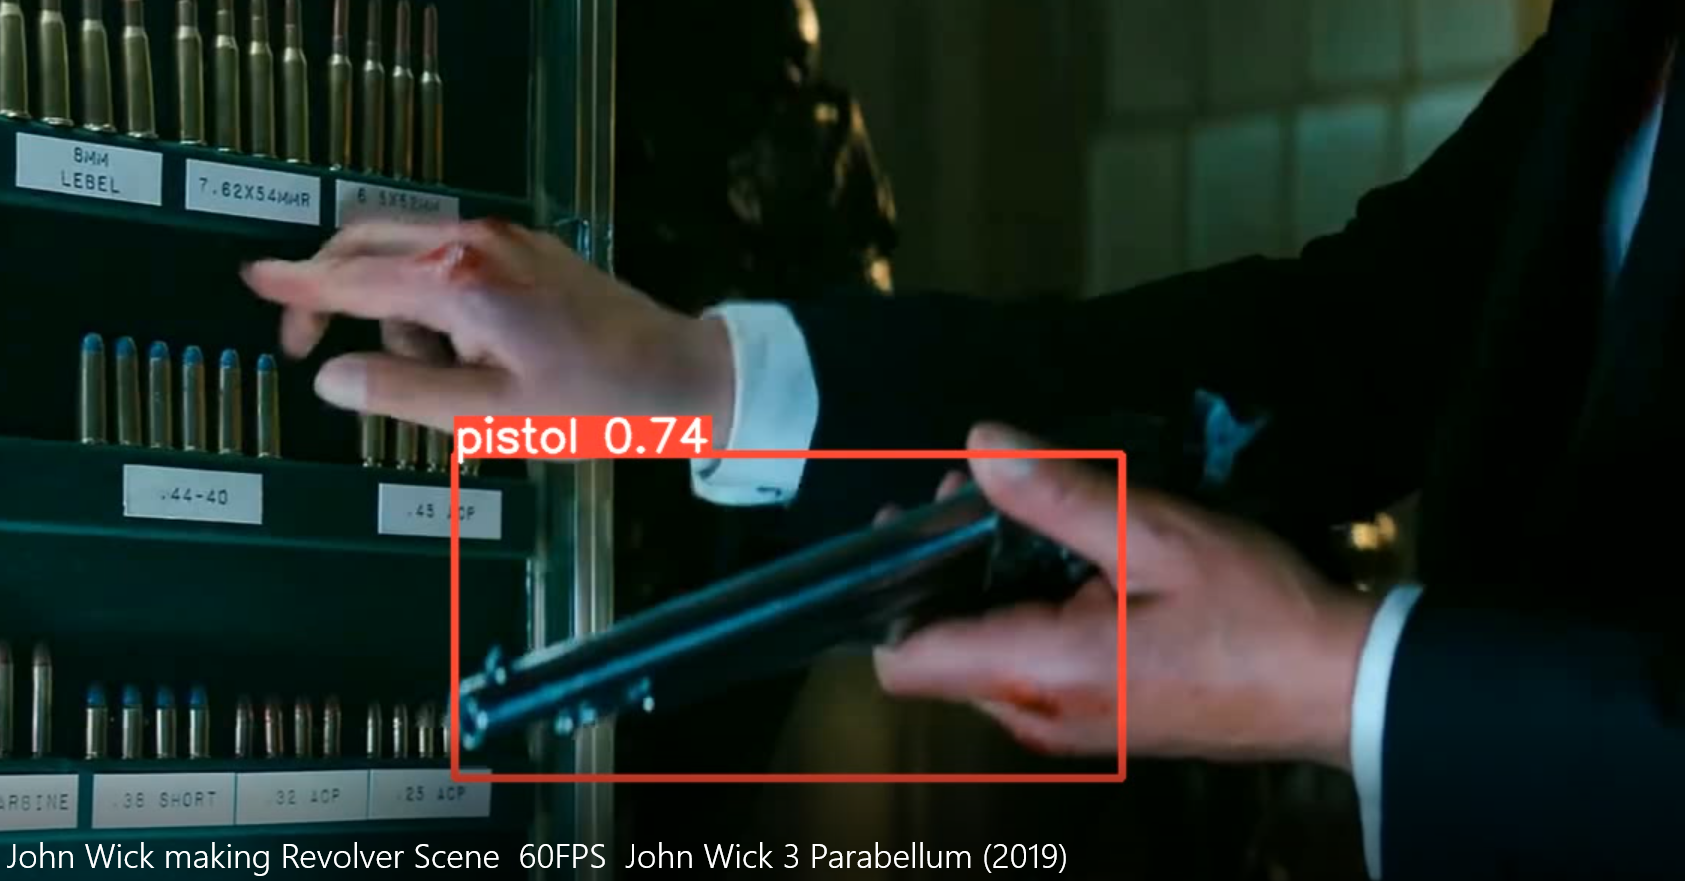

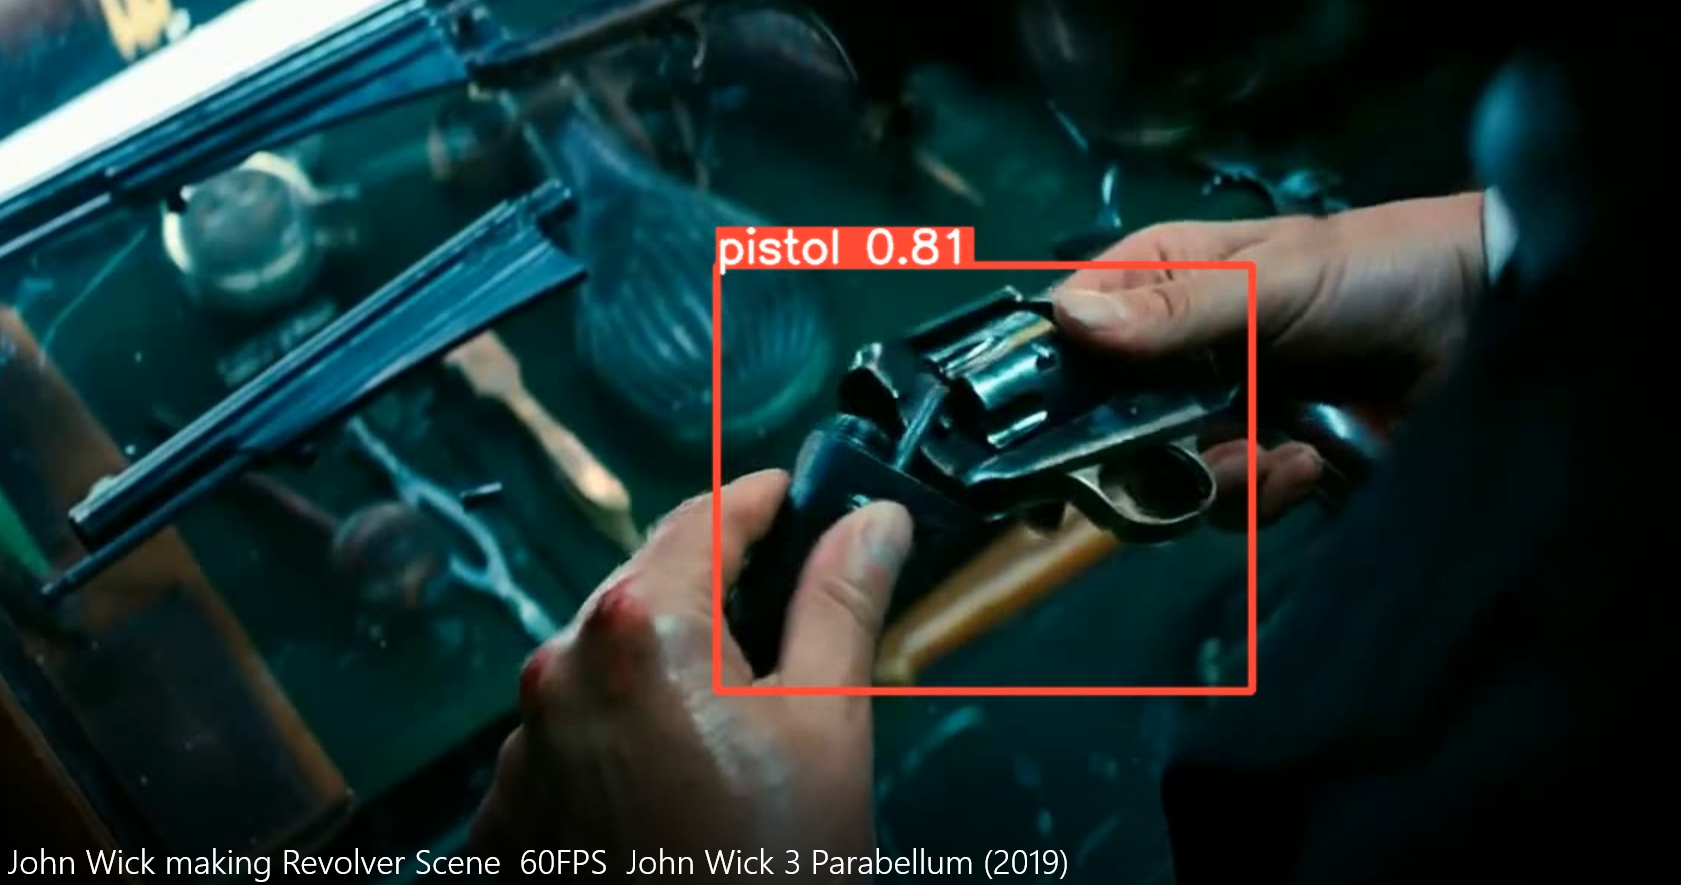

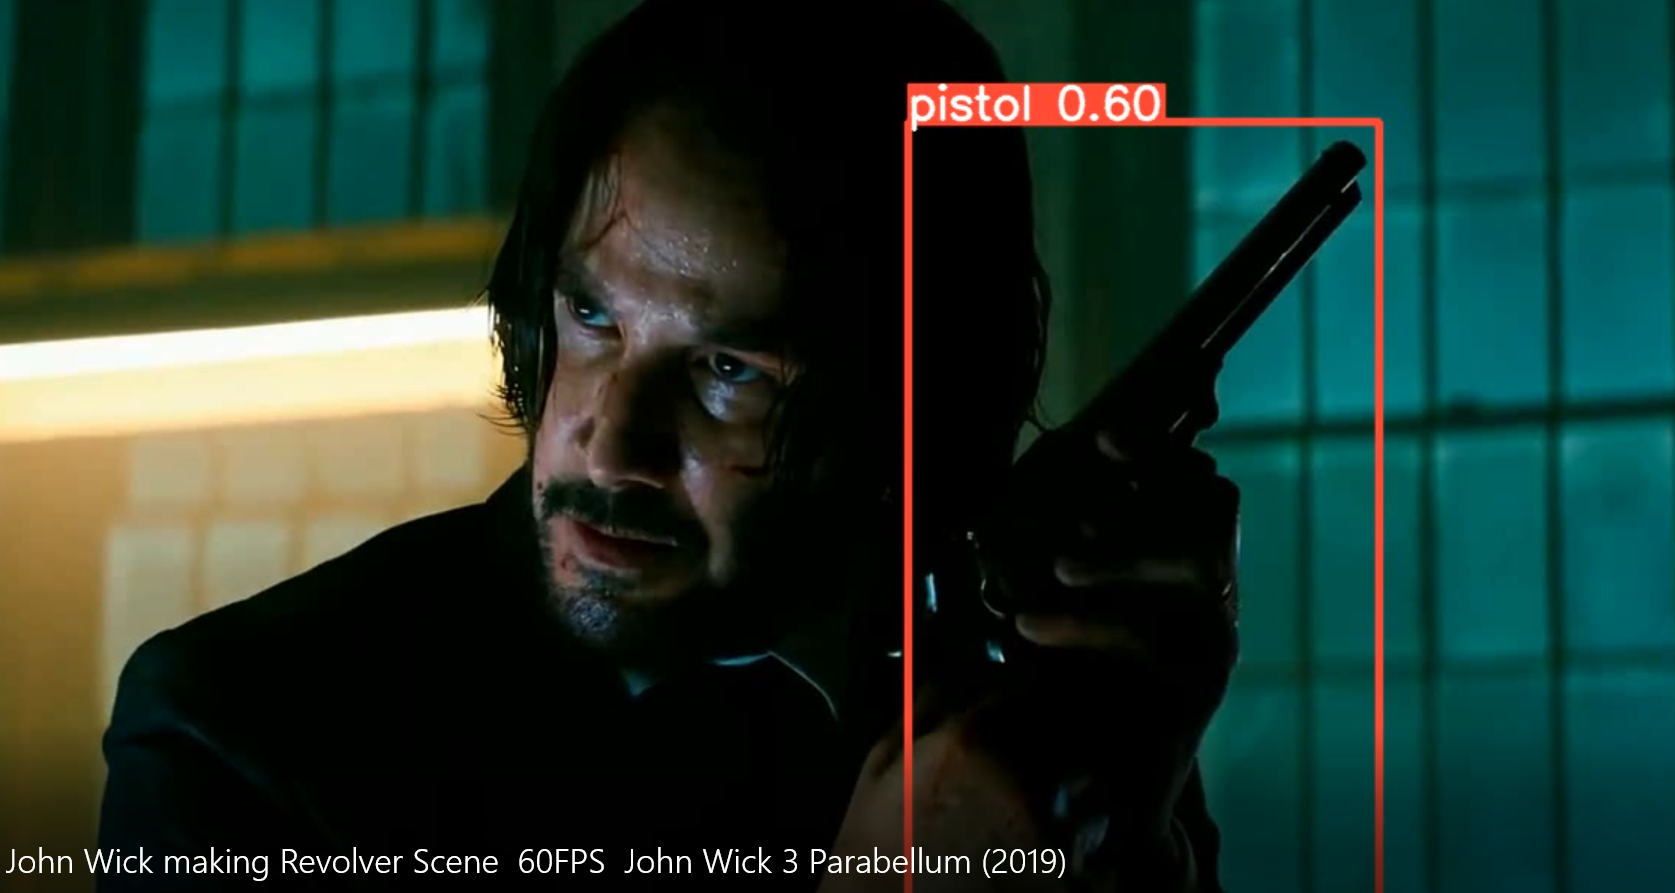